# TP3 : Devoir final : Modèles linéaires

## Setup

In [1]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.datasets.mldata import fetch_mldata
from sklearn.neighbors import KernelDensity
from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso, lasso_path, LinearRegression, LogisticRegressionCV
from sklearn import decomposition
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model.base import LinearModel

from scipy.stats import gaussian_kde, norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib

%matplotlib inline 
matplotlib.rcParams['figure.figsize']=(14,8) # Defini la taille des figures
plt.style.use('ggplot') # Style predefini pour l'affichage des figures

# Load data
dataset_name = 'leukemia'
data = fetch_mldata(dataset_name)
X = data.data
y = data.target
X = X.astype(float)
y = y.astype(float)

## Exercice 1 : Régression robuste

### Question 1

1) Donner le nombre d'observations et de variables explicatives (features) de cette base de données. Appliquer un pré-traitement afin que chaque colonne de X soit dorénavant de variance empirique égale à 1.

In [2]:
# Forme des données
print("Nombre de variables explicatives : " +  str(X.shape[1]))
print("Nombre d'observations : " +  str(X.shape[0]))

# Normalisation des données
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)
print("Variance empirique : " + str(np.var(X_std[:, 0])))

Nombre de variables explicatives : 7129
Nombre d'observations : 72
Variance empirique : 1.0


### Question 2

2) Appliquer une analyse en composantes principales (ACP) sur la matrice X, et visualiser les variables explicatives en dimension d=1, puis en dimension d=2 en projetant sur les axes principaux qui conviennent. Faire de même avec la méthode TSNE. On affichera les points de deux couleurs différentes selon leur classe.

In [3]:
# Définition des couleurs pour l'affichage des classes
my_colors = {1 : 'red', -1 : 'blue'}
colors = [my_colors[yi] for yi in y ]

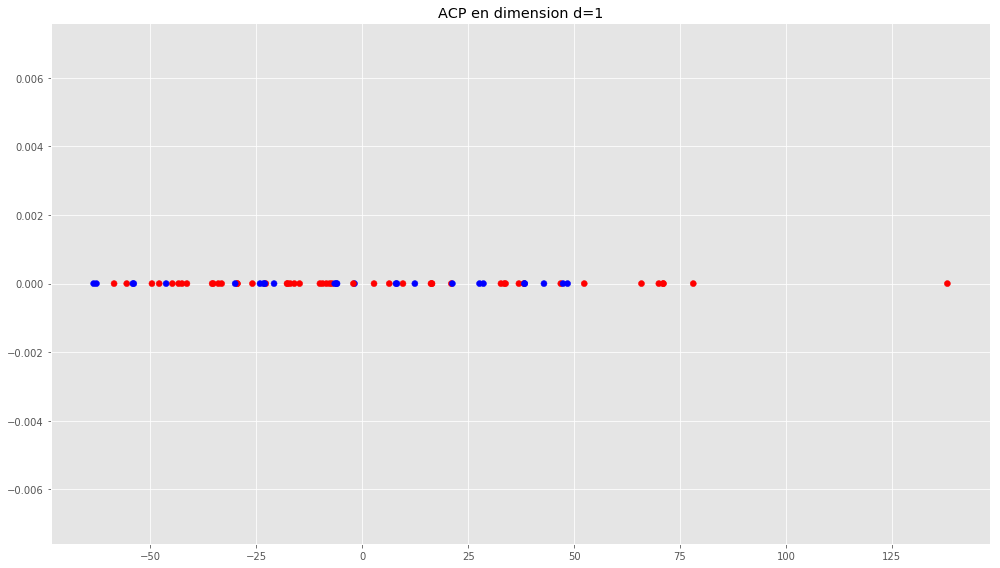

In [4]:
# Analyse PCA 1D
pca_d1 = decomposition.PCA(n_components=1).fit(X_std)
X_pca_d1 = pca_d1.transform(X_std)

# Affichage PCA 1D
plt.title('ACP en dimension d=1')
plt.scatter(X_pca_d1, np.zeros(len(X_pca_d1)), c=colors)
plt.tight_layout()
plt.show()

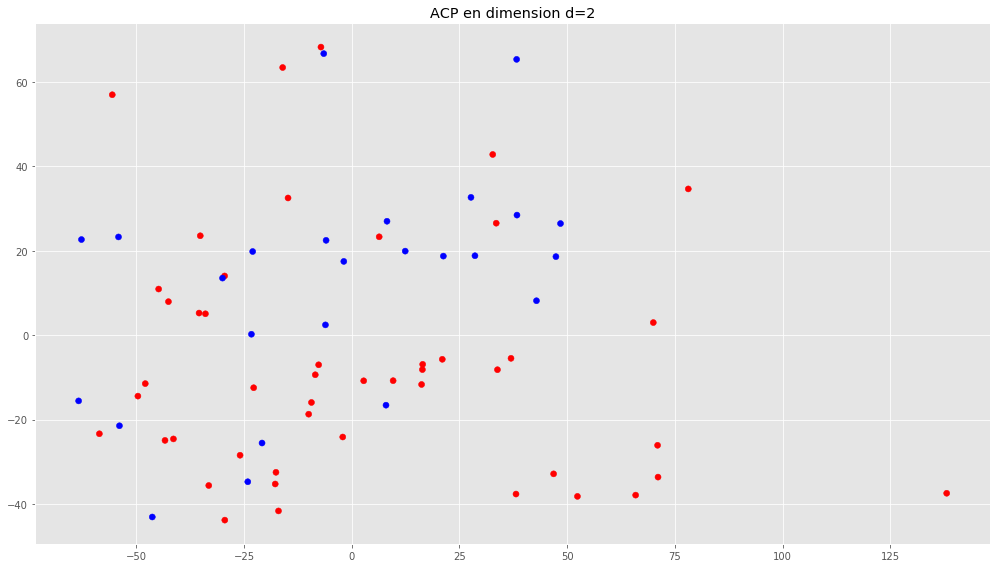

In [5]:
# Analyse PCA 2D
pca_d2 = decomposition.PCA(n_components=2).fit(X_std)
X_pca_d2 = pca_d2.transform(X_std)

# Affichage PCA 2D
plt.title('ACP en dimension d=2')
plt.scatter(X_pca_d2[:, 0], X_pca_d2[:, 1], c=colors)
plt.tight_layout()
plt.show()

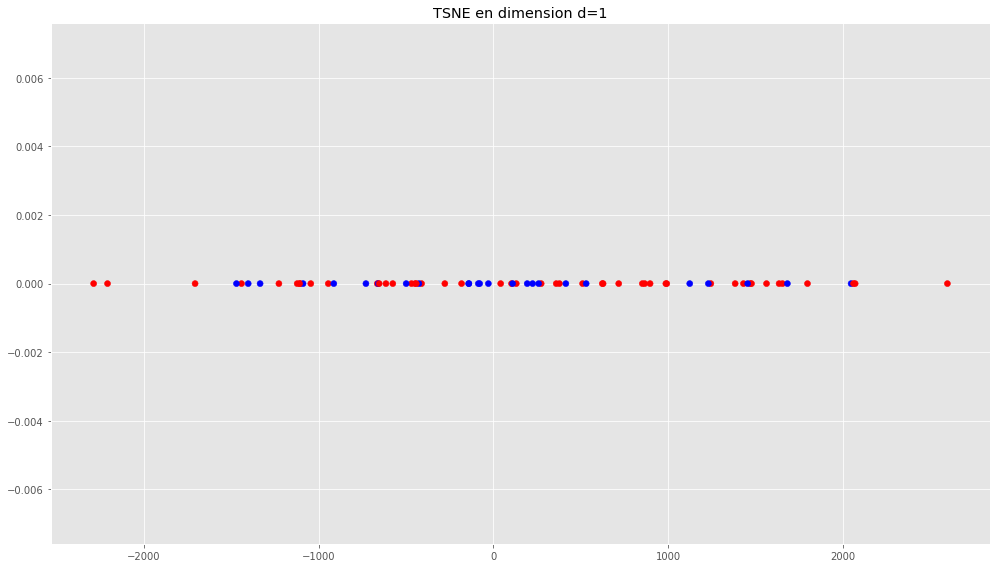

In [6]:
# Analyse TSNE 1D
tsne = manifold.TSNE(n_components=1)
X_tsne = tsne.fit_transform(X_std)

# Affichage TSNE 1D
plt.title('TSNE en dimension d=1')
plt.scatter(X_tsne, np.zeros(len(X_pca_d1)), c=colors)
plt.tight_layout()
plt.show()

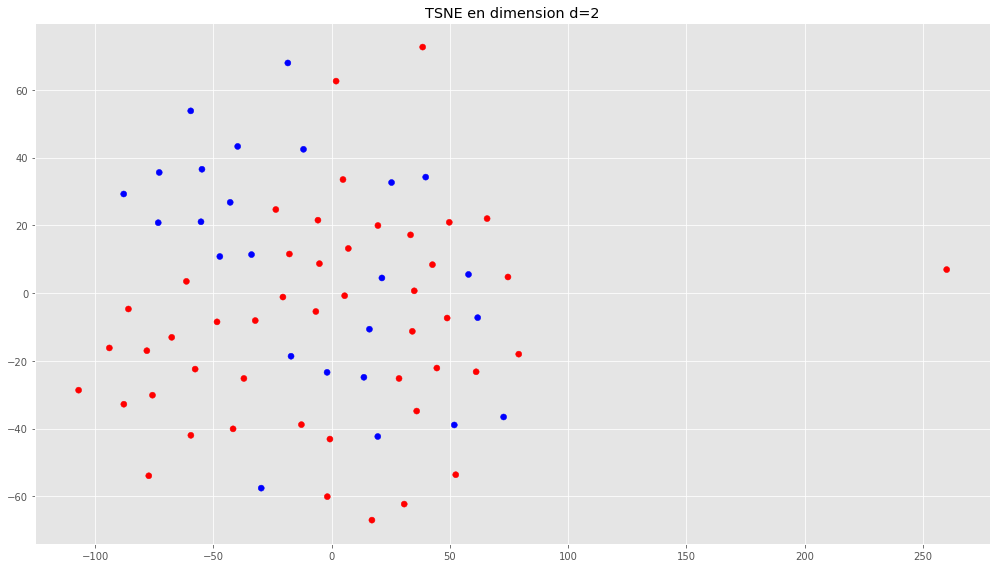

In [7]:
# Analyse TSNE 2D
tsne = manifold.TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_std)

# Affichage TSNE 2D
plt.title('TSNE en dimension d=2')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)
plt.tight_layout()
plt.show()

### Question 3

3) Couper les données en deux ensembles : un pour l'entraînement et un pour le test. On utilisera 80% des données pour l'entraînement (en utilisant par exemple la fonction model_selection.train_test_split de sklearn).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20)

print("Shape X_train : " + str(X_train.shape) + " | Shape X_test : " + str(X_test.shape)) 
print("Shape y_train : " + str(y_train.shape) + " | Shape y_test : " + str(y_test.shape)) 

Shape X_train : (57, 7129) | Shape X_test : (15, 7129)
Shape y_train : (57,) | Shape y_test : (15,)


### Question 4

4) Trouver mathématiquement λ' en fonction de λ tel que θˆLasso = θˆLasso package.

In [9]:
# Calcul Lambda du package Lasso
cv_folds = 4
lambda_lasso_package = LassoCV(fit_intercept=False, cv=cv_folds).fit(X, y)
print("Lambda du package Lasso : ", lambda_lasso_package.alpha_)

# Calcul du nombre d'observations fournies
n = X.shape[0]

# Calcul Lambda Lasso
lambda_lasso = lambda_lasso_package.alpha_ * n
print("Lambda Lasso  : ", lambda_lasso)

Lambda du package Lasso :  0.1640928922
Lambda Lasso  :  11.8146882384


### Question 5

5) Utiliser LassoCV sur (X_train, y_train)...

In [10]:
# Definition des parametres
T = 17 
delta = 2 #delta = 0.01
n = X_train.shape[0]

# Calcul lambda0_prime
lambda0_prime = np.linalg.norm(np.dot(X_train.T, y_train), ord=inf) / n

# Calcul des lambda_t_prime
lambda_t_prime = [lambda0_prime * 10**(-delta * t /(T-1)) for t in np.arange(T)]

# Calcul lassoCV sur Xtest ytest
lasso_test = LassoCV(fit_intercept=False, cv=cv_folds, alphas=lambda_t_prime).fit(X_train, y_train)
print("Lambda du lasso_test : ", lasso_test.alpha_)

# Calcul de la prediction
y_pred = lasso_test.predict(X_test)

# Affichage de l'erreur de prediction moyenne (quadratique) obtenue par LassoCV 
n_test = X_test.shape[0]
pred_err_lasso_cv = np.linalg.norm(y_pred - y_test, ord=2)**2
erreur_pred = np.linalg.norm(np.dot(X_test, lasso_test.coef_) - y_test, ord=2)**2 / n_test
print("pred_err_lasso_cv : ", pred_err_lasso_cv)
print("Erreur de prediction moyenne : " + str(erreur_pred))

# Calcul de l'erreur de prediction moyenne (quadratique) obtenue par LassoCV 
mean_mse = np.mean(lasso_test.mse_path_, axis=1)

Lambda du lasso_test :  0.145975507376
pred_err_lasso_cv :  6.90488415906
Erreur de prediction moyenne : 0.460325610604


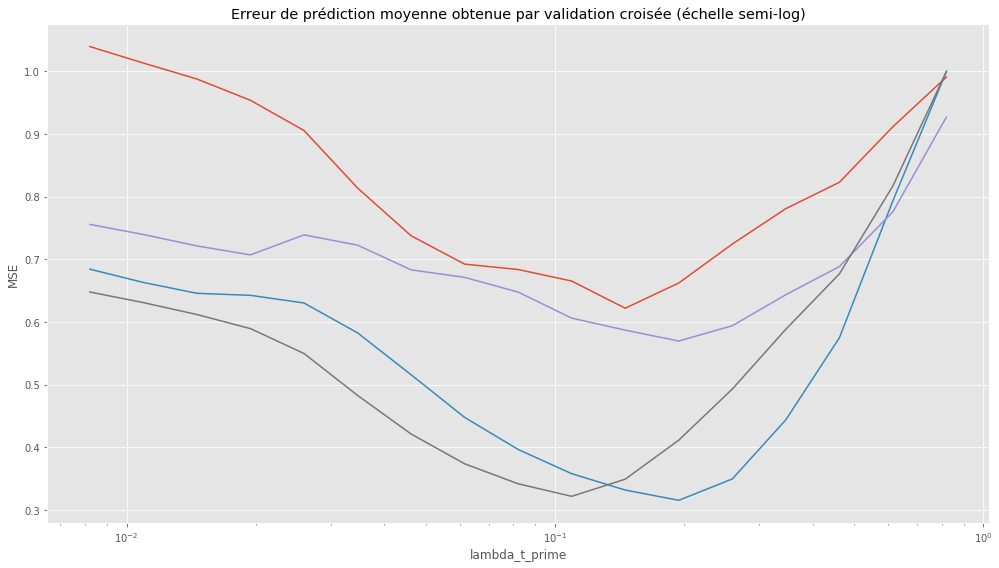

In [11]:
# Affichage graphique de l'erreur de prediction moyenne (quadratique)
plt.title('Erreur de prédiction moyenne obtenue par validation croisée (échelle semi-log)')
plt.semilogx(lambda_t_prime, lasso_test.mse_path_)
plt.xlabel("lambda_t_prime"); plt.ylabel("MSE")
plt.tight_layout()
plt.show()

### Question 6

6) Proposer et calculer un estimateur σˆ de l'écart type du bruit dans le modèle linéaire considéré.

In [12]:
variance_bruit = (1 / n_test) * np.linalg.norm(y_pred - y_test, ord=2)**2
ecart_type_bruit = np.sqrt(variance_bruit)
print("Ecart_type_bruit : " + str(ecart_type_bruit))

Ecart_type_bruit : 0.678472999171


### Question 7

7) Coder la méthode du Lasso Seuillé

In [13]:
def lasso_seuil(X, y, lambd, thau):
    theta = Lasso(fit_intercept=False, alpha=lmbd).fit(X, y).coef_
    S = []
    p = X.shape[1]
    for j in np.arange(0, p):
        if np.abs(theta[j]) < thau:
            S.append(j)
    X_S = np.take(X, S, axis=1)
    linmod = linear_model.LinearRegression(fit_intercept=False)
    linmod.fit(X_S, y)
    return linmod.coef_

### Question 8

8) Écrire une procédure de validation croisée (avec CV=4 folds) pour la procédure "Lasso Seuillé" sur la double grille en λ' et en τ (prendre seulement 5 valeurs pour τ )

In [14]:
class LassoSeuil(LinearModel, RegressorMixin):  
    """An example of classifier"""

    def __init__(self, max_iter=10000, lmbd=0.0001, thau=0.0001, fit_intercept=False):
        """
        Called when initializing the classifier
        """
        self.lmbd = lmbd
        self.thau = thau
        self.fit_intercept = fit_intercept


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.

        Note: assert is not a good choice here and you should rather
        use try/except blog with exceptions. This is just for short syntax.
        """
        self.theta = Lasso(fit_intercept=self.fit_intercept, alpha=self.lmbd).fit(X, y).coef_
        S = []
        p = X.shape[1]
        for j in np.arange(0, p):
            if np.abs(self.theta[j]) > self.thau:
                S.append(j)
        X_S = np.take(X, S, axis=1)
        linmod = linear_model.LinearRegression(fit_intercept=self.fit_intercept)
#         linmod.fit(X_S, y)
#         self.coef_ = linmod.coef_
        if len(S) == 0:
            coef = np.zeros(p,)
            self.intercept_ = np.mean(y)
        else:
            coef = np.zeros(p,)
            linmod.fit(X[:, S], y)
            coef[S] = linmod.coef_
            self.intercept_ = linmod.intercept_
        self.coef_ = coef
        return self

In [15]:
def LassoSeuilCV(X, y, lbdGrd, thGrd, cv=4, n_jobs=1, fit_intercept=False):
    param_grid = dict(lmbd=lbdGrd, thau=thGrd)
    sr_test = LassoSeuil(max_iter=10000,fit_intercept=fit_intercept)
    gs = GridSearchCV(sr_test, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    gs.fit(X, y)
    index_LassoSeuilCV = np.where(lbdGrd == gs.best_params_['lmbd'])[0]
    coef_LassoSeuilCV= gs.best_estimator_.coef_
    return coef_LassoSeuilCV, index_LassoSeuilCV

In [16]:
thau_grid = [0.00001, 0.0001, 0.001, 0.01, 0.1]
lasso_seuile = LassoSeuilCV(X_train, y_train, lambda_t_prime, thau_grid)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Libra

In [17]:
res_lasso_seuile = np.dot(X_test, lasso_seuile[0]) - y_test
pred_err_lasso_seuile = np.linalg.norm(res_lasso_seuile, ord=2)**2
print("Lasso Seuillé : ", pred_err_lasso_seuile)

Lasso Seuillé :  6.14579841874


### Question 9

9) Comparer l'erreur de prédiction obtenue sur la partie "test" pour :

(a) le "Lasso Seuillé" avec validation croisée (de la question précédente)

(b) le LassoCV (de la question 5, sans intercept).

(c) l'estimateur des moindres carrées (sans intercept).

In [18]:
# Moindres carées
moindres_carrees = LinearRegression(fit_intercept=False)
moindres_carrees.fit(X_train, y_train)
y_pred_moindres_carrees = moindres_carrees.predict(X_test)

res_moindres_carrees = y_pred_moindres_carrees - y_test
pred_err_moindres_carrees = np.linalg.norm(res_moindres_carrees, ord=2)**2

print("Lasso Seuillé : ", pred_err_lasso_seuile)
print("LassoCV : ", pred_err_lasso_cv)
print("Moindres carées : ", pred_err_moindres_carrees)

Lasso Seuillé :  6.14579841874
LassoCV :  6.90488415906
Moindres carées :  35.1259726108


> L'erreur minimale de prédiction sur la partie "test" est obtenue par le "Lasso Seuillé" avec validation croisée.

### Question 10

10) Reprendre l'ensemble des comparaisons précédentes, mais cette fois en tenant compte de l'intercept dans votre démarche.

In [19]:
# Lasso Seuillé
lasso_seuile = LassoSeuilCV(X_train, y_train, lambda_t_prime, thau_grid, fit_intercept=True)
res_lasso_seuile = np.dot(X_test, lasso_seuile[0]) - y_test
pred_err_lasso_seuile = np.linalg.norm(res_lasso_seuile, ord=2)**2
print("Lasso Seuillé : ", pred_err_lasso_seuile)

Lasso Seuillé :  5.04863091151


In [20]:
# LassoCV
lassoCV_10 = LassoCV(fit_intercept=True, cv=cv_folds, alphas=lambda_t_prime).fit(X_train, y_train)
y_pred_lassoCV_10 = lassoCV_10.predict(X_test)
res_lassoCV_10 = y_pred_lassoCV_10 - y_test

pred_err_lassoCV_10 = np.linalg.norm(res_lassoCV_10, ord=2)**2
print("Erreur moyenne de prediction", pred_err_lassoCV_10)

Erreur moyenne de prediction 1.87229532135


In [21]:
# Moindres carées
moindres_carrees_10 = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_pred_moindres_carrees_10 = moindres_carrees_10.predict(X_test)
res_moindres_carrees_10 = y_pred_moindres_carrees_10 - y_test

pred_err_moindres_carrees_10 = np.linalg.norm(res_moindres_carrees_10, ord=2)**2
print("Moindres carées : ", pred_err_moindres_carrees_10)
print("Erreur moyenne de prediction", pred_err_lassoCV_10)
print("Lasso Seuillé : ", pred_err_lasso_seuile)

Moindres carées :  2.91641973327
Erreur moyenne de prediction 1.87229532135
Lasso Seuillé :  5.04863091151


> En tenant compte de l'intercept, la méthode la plus performante est donc le lasso seuillé.

### Question 11

11) Comparer (sur la partie test) les performances des deux méthodes suivantes :

(a) le LassoCV modiffié pour retourner une prédiction valant soit 1 soit -1

(b) la LogisticRegressionCV.

On utilisera ici l'erreur 0/1 (i.e., la proportion d'erreurs de "classe" faites) comme mesure de performance

In [22]:
lrCV = LogisticRegressionCV(cv=cv_folds, fit_intercept=False)
lrCV.fit(X_train, y_train)
n_test = X_test.shape[0]

# LassoCV modiffié
y_pred_lassoCV = [-1 if y < 0 else 1 for y in y_pred]
print("Nombre de classes avec une erreur de prediction avec LassoCV : ", np.sum(y_test != y_pred_lassoCV) / n_test)

# LogisticRegressionCV
y_pred_lrCV = lrCV.predict(X_test)
print("Nombre de classes avec une erreur de prediction avec LogisticRegressionCV: ", np.sum(y_test != y_pred_lrCV) / n_test)

Nombre de classes avec une erreur de prediction avec LassoCV :  0.133333333333
Nombre de classes avec une erreur de prediction avec LogisticRegressionCV:  0.266666666667


> La méthode la plus performante est donc la "LogisticRegressionCV".